# Camera Calibration
## Computer Vision and Image Processing - Lab Session 4 Excerices Solutions
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Andrea Amaduzzi, andrea.amaduzzi4@unibo.it - Iacopo Curti, iacopo.curti2@unibo.it

## Exercise 0: Calibrate your own camera (or Sample Camera)

Try to reimplement the code explained in the theory. Acquire a set of images with a camera (e.g. your mobile phone camera) and calibrate it. For the calibration target print the chessboard.pdf in a A4 paper.
If you are not able to use a camera use the sample images contained in "calibration_images/*.jpg"

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

dirname = "chessboards/"
img_names = [dirname + str(i) + ".jpg" for i in range(13)]

square_size = 26.5 #mm
pattern_size = (8,5) # number of inner corner

#Building 3D points
indices = np.indices(pattern_size, dtype=np.float32)
indices *= square_size
pattern_points = np.zeros([pattern_size[0]*pattern_size[1], 3], np.float32)
coords_3D = indices.T.reshape(-1, 2)
pattern_points[:, :2] = coords_3D

def processImage(fn):
    print('processing {}'.format(fn))
    img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print("Failed to load", fn)
        return None

    found, corners = cv2.findChessboardCorners(img, pattern_size)

    if found:
        #Refining corner position to subpixel iteratively until criteria  max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        #Image Corners 
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
        
    if not found:
        print('chessboard not found')
        return None

    print('           %s... OK' % fn)
    return (corners.reshape(-1, 2), pattern_points)

# Building 2D-3D correspondeces
chessboards = [processImage(fn) for fn in img_names]
chessboards = [x for x in chessboards if x is not None]

obj_points = [] #3D points
img_points = [] #2D points

for (corners, pattern_points) in chessboards:
        img_points.append(corners)
        obj_points.append(pattern_points)

# Getting the width and height of the images
h, w = cv2.imread(img_names[0], cv2.IMREAD_GRAYSCALE).shape[:2]

# Calibrating Camera
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

processing chessboards/0.jpg
           chessboards/0.jpg... OK
processing chessboards/1.jpg
           chessboards/1.jpg... OK
processing chessboards/2.jpg
           chessboards/2.jpg... OK
processing chessboards/3.jpg
           chessboards/3.jpg... OK
processing chessboards/4.jpg
           chessboards/4.jpg... OK
processing chessboards/5.jpg
           chessboards/5.jpg... OK
processing chessboards/6.jpg
           chessboards/6.jpg... OK
processing chessboards/7.jpg
           chessboards/7.jpg... OK
processing chessboards/8.jpg
           chessboards/8.jpg... OK
processing chessboards/9.jpg
           chessboards/9.jpg... OK
processing chessboards/10.jpg
           chessboards/10.jpg... OK
processing chessboards/11.jpg
           chessboards/11.jpg... OK
processing chessboards/12.jpg
           chessboards/12.jpg... OK


## Exercise 1A: 3D-2D correspondence

Using image "chessboards/0.jpg" and the calibration results, find the 2D point correspondent to the 3D point (53, 53, 0) and draw a red circle around it.
Solve the exercise in two different ways:

* Use the OpenCV function cv2.projectPoints(objectPoints, rvec, tvec, cameraMatrix, distCoeffs).
* Do it "manually" using the PPM matrix derived from the calibration parameters obtained in the previous exercise.

Using cv2.projectPoints:
2D point using PPM:  [1374 1397]


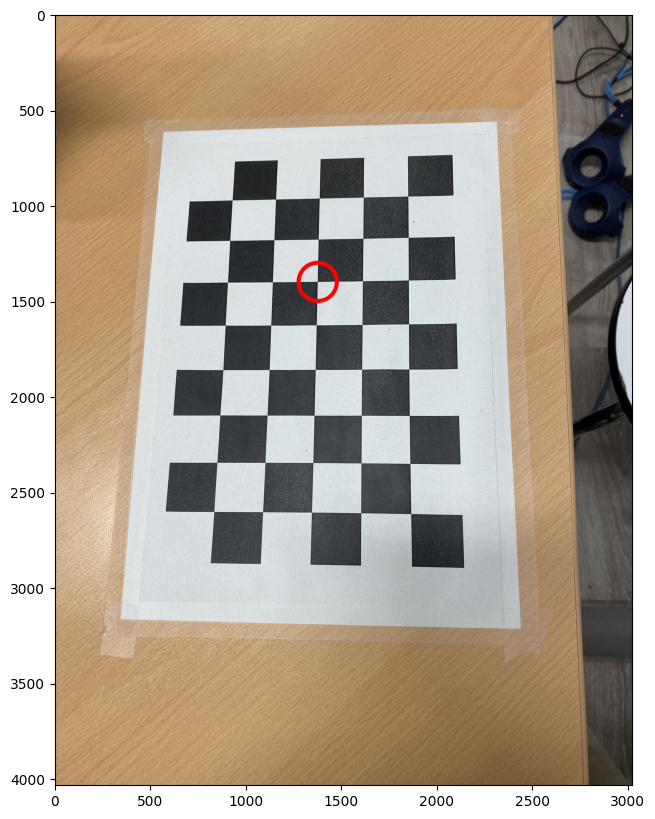

Using PPM:
2D point using PPM (Coordinates referred to the undistorted image):  (1378, 1391)


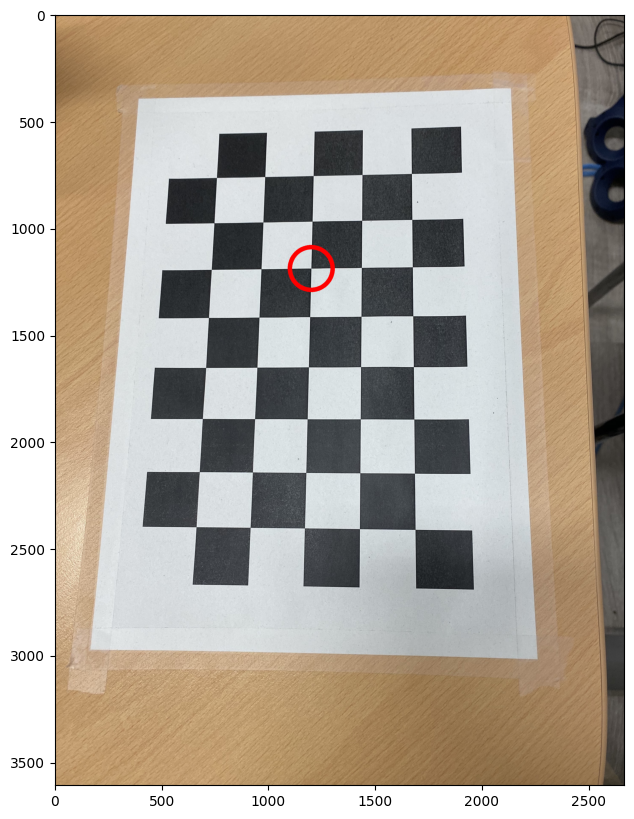

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Read the image
img = cv2.imread('chessboards/0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define the 3D point
_3d_point = np.array([[53., 53., 0.]], dtype = np.float32)

# Find 2D correspondences with ProjectPoints function.
# projectPoints already consider distorsion coefficients so no need to undistort the imagebefore
# In case you will use the undistorted image you have to pass newcameramtx instead of camera_matrix
# and np.array([0.,0.,0.,0.,0.]) instaead of dist_coefs because distorsion is 0 in undistorted image

print('Using cv2.projectPoints:')
_2d_point = cv2.projectPoints(_3d_point, rvecs[0], tvecs[0], camera_matrix, dist_coefs)[0][0,0]
_2d_point = np.round(_2d_point).astype(int)

print("2D point using PPM: ", _2d_point)

# Draw a circle around the point
img1 = np.copy(img)
cv2.circle(img1, (_2d_point[0], _2d_point[1]), 100, (255,0,0), 20)
plt.figure(figsize=(10, 10))
plt.imshow(img1)
plt.show()

# Second way
# First undistort image to make the PPM working better removing the lens distorsion.
# If the lens distorsion is small you shoud not see big differences
# We have to do it since the homography is a linear transformation and cannot remap nonlinear deformations

newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))
x, y, w_2, h_2 = roi
img_undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)

# Find the results calcultaing the PPM from A,R and T
print('Using PPM:')
R = np.asarray(cv2.Rodrigues(rvecs[0])[0])
T = np.asarray(tvecs[0])
A = newcameramtx # We use the undistorted image so we have to change A to the new optimal for the undistorted image

# Building the PPM
PPM = np.matmul(A, np.concatenate((R, T), axis=1))

# Define the 3D point in homogeneous coordinate in order to multiply with the PPM 
_3d_point_homogeneous = np.array([[53.], [53.], [0.], [1.]])

# Multiply by the PPM obtaining the pixel in homogeneous coordinate
_2d_point_homogeneous = np.matmul(PPM, _3d_point_homogeneous)

# Divide by the third value to get the pixel coordinate
_2d_point = _2d_point_homogeneous / _2d_point_homogeneous[-1, 0]

print("2D point using PPM (Coordinates referred to the undistorted image): ", ( int(round(_2d_point[0,0])), int(round(_2d_point[1,0])) ))

# Draw the point
img2 = np.copy(img_undistorted)
cv2.circle(img2, (int(_2d_point[0]),int( _2d_point[1])), 100, (255,0,0), 20)

# Crop away the black region obtained by undistorsion
img2 = img2[y:y+h_2, x:x+w_2]

plt.figure(figsize=(10, 10))
plt.imshow(img2)
plt.show()

## Exercise 1 B:
Find the 3D point correspondent to the 2D point of the (2,2) corner. Do it first using the PPM derived from the calibration parameters and then using a new homography (calculated with cv2.findHomography).

The expected result is approximately (53,53,0).

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Read the image
img = cv2.imread('chessboards/0.jpg')
h, w = img.shape[:2]

# First undistort image to make the PPM working better removing the lens distorsion.
# If the lens distorsion is small you shoud not see big differences
# Crop away the black regions only after all the computation 
# because crop change the dimension of the image leading to wrong results
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))
x, y, w_2, h_2 = roi
img = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)

# define chessboard params
square_size = 26.5 #mm
pattern_size = (8,5) # number of inner corner

# build chessboard 3D points
indices = np.indices(pattern_size, dtype=np.float32)
indices *= square_size
pattern_points = np.zeros([pattern_size[0]*pattern_size[1], 3], np.float32)
coords_3D = indices.T.reshape(-1, 2)
pattern_points[:, :2] = coords_3D

# processImage takes the undistorted image in this case
def processImage(img):
    print('processing')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(img, pattern_size)

    if found:
        #Refining corner position to subpixel iteratively until criteria  max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        #Image Corners 
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
        
    if not found:
        print('chessboard not found')
        return None

    print('           ... OK')
    return (corners.reshape(-1, 2), pattern_points)

corners, pattern_points = processImage(img)

# Getting the position of corner (2,2)
_2d_point = corners[pattern_size[0]*2 + 2] # Corner (2,2) 2D position
_2d_point_homogeneous = np.concatenate([_2d_point, [1]])

# find the homography between 3D points and 2D points
homography = cv2.findHomography(pattern_points, corners, 0)[0]

# use the inverse of the homography to project the 2D point to the 3D point
_3d_point_homogeneous = np.matmul(np.linalg.inv(homography), _2d_point_homogeneous)

# transform homogeneous coordinates in euclidean coordinates
_3d_point = _3d_point_homogeneous / _3d_point_homogeneous[-1]

# force the 3D point to be on the chessboard plane
_3d_point[-1] = 0.

_3d_point = _3d_point.reshape([1,3])
print('\nCorresponding 3D point using new homography:', _3d_point[0])

# SECOND WAY: USE THE PPM
# Find the results calculating the PPM from A,R and T
print('Using PPM:')
R = np.asarray(cv2.Rodrigues(rvecs[0])[0])
T = np.asarray(tvecs[0])
A = newcameramtx # We use the undistorted image so we have to change A to the new optimal for the undistorted image

# Building the PPM
PPM = np.matmul(A, np.concatenate((R, T), axis=1))

# P as Homography
homography = np.concatenate([PPM[:, :2], PPM[:,3:]], axis=1)

# use the inverse of the homography to project the 2D point to the 3D point
_3d_point_homogeneous = np.matmul(np.linalg.inv(homography), _2d_point_homogeneous)

# transform homogeneous coordinates in euclidean coordinates
_3d_point = _3d_point_homogeneous / _3d_point_homogeneous[-1]

# force the 3D point to be on the chessboard plane
_3d_point[-1] = 0.

_3d_point = _3d_point.reshape([1,3])
print('\nCorresponding 3D point using PPM:', _3d_point[0])

processing
           ... OK

Corresponding 3D point using new homography: [52.9872404  52.99365471  0.        ]
Using PPM:

Corresponding 3D point using PPM: [52.99575453 52.98176878  0.        ]


## Exercise 2: 3D Measureaments in mm

Take an image with an object belonging to same plane of the chessboard (the chessboard has to be in the image). If you cannot use your camera try on "es2/pen.jpg".

Measure the lenght of that object in mm.

Get the 2D image coordinates using the Image Visualization Tool in LabSession3Exercise3VisualizationTool.ipynb

Expected_results: 145.56mm

<img src="LabSession4Images/pen_lenght.png" width=256>

**Tips (Only if needed)**
* Find the homography given 2D-3D correspondences
* Get the coordinate of two pixels of the object
* Apply the same transformation as in Exercise 1b to get the 3D coordinate of those pixels
* Find the euclidean distance between two 3D points to get your mesuraments

processing es2/pen.jpg
           es2/pen.jpg... OK
2D:  (2722, 1160) (2686, 2675)
3D:  [182.19312107 177.43547352   0.        ] [ 36.67644931 181.04560459   0.        ]
145.56mm


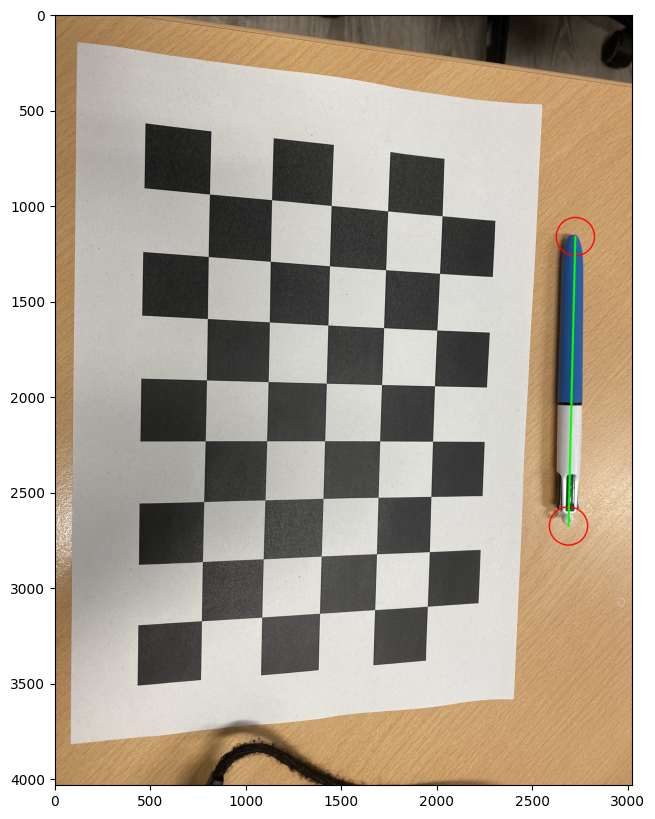

In [4]:
# Distorsion ignored in this exercise. Try to add the undistorsion in your solution.

import numpy as np
import cv2

image_name = "es2/pen.jpg"
image = cv2.imread(image_name)

square_size = 26.5 #mm
pattern_size = (8,5) # number of inner corner

#Building 3D points
indices = np.indices(pattern_size, dtype=np.float32)
indices *= square_size
pattern_points = np.zeros([pattern_size[0]*pattern_size[1], 3], np.float32)
coords_3D = indices.T.reshape(-1, 2)
pattern_points[:, :2] = coords_3D

def processImage(fn):
    print('processing {}'.format(fn))
    img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print("Failed to load", fn)
        return None

    found, corners = cv2.findChessboardCorners(img, pattern_size)

    if found:
        #Refining corner position to subpixel iteratively until criteria  max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        #Image Corners 
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
        
    if not found:
        print('chessboard not found')
        return None

    print('           %s... OK' % fn)
    return (corners.reshape(-1, 2), pattern_points)

# Building 2D-3D correspondeces
corners, pattern_points = processImage(image_name)

# Finding homography between the two sets of points
homography = cv2.findHomography(pattern_points, corners)[0] #from 3D to 2D

# Find 2D points A,B using the Visualization tool
point2D_homogeneous_a = (2722, 1160, 1)
point2D_homogeneous_b = (2686, 2675, 1)

# Find 3D coordinates  
point3D_homogeneous_a = np.matmul(np.linalg.inv(homography), point2D_homogeneous_a)
point3D_a = point3D_homogeneous_a/point3D_homogeneous_a[-1]
point3D_a[-1] = 0

point3D_homogeneous_b = np.matmul(np.linalg.inv(homography), point2D_homogeneous_b)
point3D_b = point3D_homogeneous_b/point3D_homogeneous_b[-1]
point3D_b[-1] = 0

print("2D: ", point2D_homogeneous_a[:-1], point2D_homogeneous_b[:-1])
print("3D: ", point3D_a, point3D_b)

# Drawing line and circles
cv2.circle(image, (point2D_homogeneous_a[0], point2D_homogeneous_a[1]), 100, (0,0,255), 5)
cv2.circle(image, (point2D_homogeneous_b[0], point2D_homogeneous_b[1]), 100, (0,0,255), 5)
cv2.line(image, (point2D_homogeneous_a[0], point2D_homogeneous_a[1]),  (point2D_homogeneous_b[0], point2D_homogeneous_b[1]),(0,255,0),10)

dist = np.linalg.norm(point3D_a-point3D_b)
print("{:.2f}mm".format(dist))

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

## Exercise 3: Augmented Reality 

Given an image, project it on the chessboard to cover all the corners of the image. Try to get restore the values of the original image (the one with the chessboard) instead of black pixels obtained with warping.

Get the 2D image coordinates using the Image Visualization Tool in LabSession3Exercise3VisualizationTool.ipynb or with cv2.findChessboardCorners.

Test the algorithm on "es3/stregatto.jpg" and "es3/stregatto2.jpg".

Expected result:
<img src="LabSession4Images/stregatto_appear.png" width=256>
**Tips (Only if needed)**
* Find the 4 points in the image where you would like to project the image with the chessboard
* Find the Perspective Transformation
* Warp the image
* Understand what are the points to restore with the original values
* Restore the values in those pixels

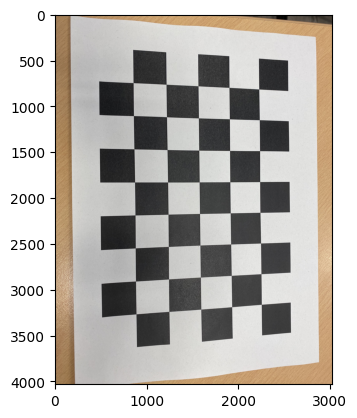

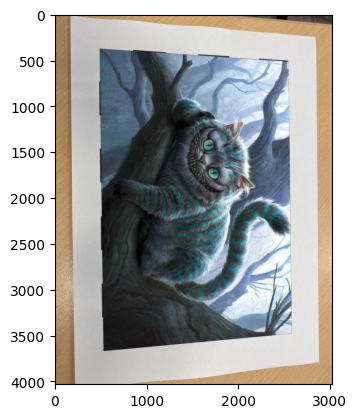

In [5]:
# Distorsion ignored in this exercise. Try to add the undistorsion in your solution.

import numpy as np
import cv2
from matplotlib import pyplot as plt 

image = cv2.imread("es3/chessboard.jpg")
image2project = cv2.imread("es3/stregatto2.jpg") 

h, w = image.shape[0], image.shape[1]
h_2, w_2=  image2project.shape[0], image2project.shape[1]

# Coordinate of the chessboard in 0.jpg
rect = np.array([
    [2537, 519],
    [2573, 3480],
    [530, 3670],
    [488, 380]
], dtype = "float32")

# Coordinate of the border of the image we want to project
dst = np.array([
[0, 0],
[w_2 - 1, 0],
[w_2 - 1, h_2 - 1],
[0, h_2 - 1]], dtype = "float32")

# Compute the perspective transform matrix 
M = cv2.getPerspectiveTransform(dst,rect)

# Apply the transformation matrix 
warped = cv2.warpPerspective(image2project, M, (w, h))

# Warp a white mask to understand what are the black pixels
white = np.ones([h_2,w_2,3],dtype=np.uint8)*255
warp_mask = cv2.warpPerspective(white, M, (w, h))
warp_mask = np.equal(warp_mask, np.array([0,0,0]))

# Restore previous values
warped[warp_mask] = image[warp_mask]

# Display original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Display warped image
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

## Exercise 4: Removal of perspective deformation 

Given a chessboard image remove the perspective deformation on the paper containing the chessboard and save it in a new image.

Get the 2D image coordinates using the Image Visualization Tool in LabSession3Exercise3VisualizationTool.ipynb

Test the exercise on "es4/pen.jpg"

Expected Results: 
<img src="LabSession4Images/perspective_deform.png" width=256>

**Tips (Only if needed)**
* Find the 4 points in the image of the corner of the paper 
* Understand what will be the dimension of the resulting image
* Find the Perspective Transformation
* Warp the paper into a new image (with the new dimensions you found)

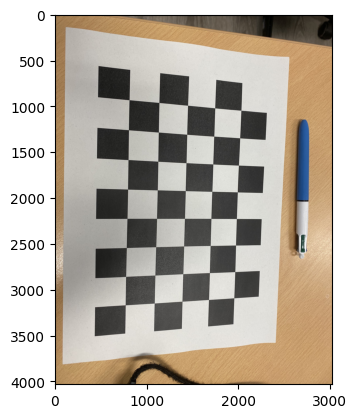

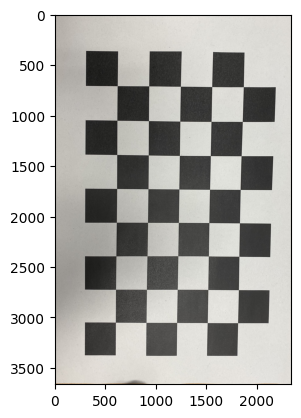

In [6]:
# Distorsion ignored in this exercise. Try to add the undistorsion in your solution.

import numpy as np
import cv2

image = cv2.imread("es4/pen.jpg")

# Getting the 2D coordinate of the points of the corner of the paper
points = np.array([[93,3823], [124,160], [2448,472], [2404, 3572]])

# initialzie a list of coordinates that will be ordered such that the first entry in the list is the top-left,
# the second entry is the top-right, the third is the bottom-right, and the fourth is the bottom-left
rect = np.zeros((4, 2), dtype = "float32")
        
# the top-left point will have the smallest sum, whereas the bottom-right point will have the largest sum
s = points.sum(axis = 1)
rect[0] = points[np.argmin(s)]
rect[2] = points[np.argmax(s)]

# now, compute the difference between the points, the top-right point will have the smallest difference, whereas the bottom-left will have the largest difference
diff = np.diff(points, axis = 1)
rect[1] = points[np.argmin(diff)]
rect[3] = points[np.argmax(diff)]

# we have the ordered coordinates obtain a consistent order of the points and unpack them individually
(tl, tr, br, bl) = rect

# compute the width of the new image, which will be the maximum distance between bottom-right and bottom-left x-coordiates or the top-right and top-left x-coordinates
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))

# compute the height of the new image, which will be the maximum distance between the top-right and bottom-right y-coordinates or the top-left and bottom-left y-coordinates
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))

# now that we have the dimensions of the new image, construct the set of destination points to obtain a "birds eye view",
# (i.e. top-down view) of the image, again specifying points  in the top-left, top-right, bottom-right, and bottom-left  order
dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")

# compute the perspective transform matrix and then apply it
M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()